# École Polytechnique de Montréal

Département Génie Informatique et Génie Logiciel
INF8460 – Traitement automatique de la langue naturelle

#### Prof. Amal Zouaq
#### Chargé de laboratoire: Félix Martel

# TP 3

## Objectifs

 - Implanter des modèles de classification neuronaux
 - Utiliser des plongements lexicaux pré-entrainés


## Travail à faire

Comme dans le TP précédent, on va travailler sur l'analyse de sentiment en utilisant les données du [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

Vous devez utiliser `scikit-learn` pour la régression logistique, et Keras pour les modèles neuronaux.

Les sections 1, 2 et 3 sont indépendantes.

Vous êtes libres d'appliquez les pré-traitements que vous jugerez utiles.

### 1. Pré-traitement et lecture de données

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
import os
data_path = './../../TP2/data/aclImdb/'

def data_reader(path):
    """ Cette fonction lit les données text et sauvegarde les labels. 
    
    :param path : str, Chemin vers le dossier contenant les données.
    :return X,y: list,list, X est une liste contenant les textes et y est une liste contenant les labels"""
    
    X = []
    y = []
    for label in ['pos','neg']:
        dir_path = path+label+'/'
        for filename in os.listdir(dir_path) :
            filepath = dir_path+filename
            with open(filepath,'r', encoding = 'utf-8') as file_descriptor:
                X.append(file_descriptor.read())
                y.append(label)
    return X,y

X_train, y_train = data_reader(data_path+'train/')
X_test, y_test = data_reader(data_path+'test/')

In [3]:
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer

stop = stopwords.words("english")
reTokenizer = RegexpTokenizer('[A-Z|a-z]+')

def clean_doc(document):
    """Effectue les pré-traitements suivants  à un document : 
    segmentation en mots ; 
    suppression des signes de ponctuations ; 
    suppression des mots qui contiennent des caractères autres qu’alphabétiques ; 
    suppression des mots qui sont connus comme des stop words ; 
    suppression des mots qui ont une longueur de 1 caractère.
    
    :param sentence : str, le texte lu à partir d'un fichier de données.
    :return : list, liste de tokens traités.
    """
    
    #Segmentation en mots et suppression des signes de ponctuation
    tokens = reTokenizer.tokenize(document)
    #Suppression des stopwords
    tokens = [token.lower() for token in tokens if token.lower() not in stop]
    #Suppression des mots d'une longueur de 1 caractère
    tokens = [token for token in tokens if len(token) > 1]
    return tokens

def clean_corpus(corpus):
    """Effectue les pré-traitements suivants  à l'ensemble du corpus : 
    segmentation en mots ; 
    suppression des signes de ponctuations ; 
    suppression des mots qui contiennent des caractères autres qu’alphabétiques ; 
    suppression des mots qui sont connus comme des stop words ; 
    suppression des mots qui ont une longueur de 1 caractère.
    
    :param sentence : str, le texte lu à partir d'un fichier de données.
    :return : list, liste de tokens traités.
    """
    
    return [clean_doc(doc) for doc in corpus]
    

#Affichage d'un test
print(X_train[0])
print(clean_doc(X_train[0]))

#Application de clean_doc à l'ensemble du corpus
X_train = clean_corpus(X_train)
X_test = clean_corpus(X_test)

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!
['bromwell', 'high', 'cartoon', 'comedy', 'ran', 'time', 'programs', 'school', 'life', 'teachers', 'years', 'teaching', 'profession', 'lead', 'believe', 'bromwell', 'high', 'satire', 'much', 'c

In [4]:
from nltk.lm.vocabulary import Vocabulary
from nltk.lm.preprocessing import padded_everygram_pipeline

def build_voc(corpus):
    """
    Extrait les unigrammes de l’ensemble d’entraînement et conserve ceux qui ont une fréquence d’occurrence de 5 au moins
    :param corpus: list(list(str)), un corpus tokenizé
    :return: None
    """
    ngrams, words = padded_everygram_pipeline(1, corpus)
    vocab = Vocabulary(words, unk_cutoff=5)
    print("Nombre de mots dans le vocabulaire:",len(vocab)-1) 
    
    with open('./../../TP2/output/vocab.txt',"w") as f:
        for word in list(vocab)[:-1]:
            f.write(word+'\n')
    f.close()
    return None

build_voc(X_train)

Nombre de mots dans le vocabulaire: 28600


In [5]:
def get_top_unigrams(corpus, n, unk_cutoff = 5):
    """
    Retourne les  𝑛  unigrammes les plus fréquents et les affiche
    :param corpus: list(list(str)), un corpus tokenizé
    :param n: int, nombre d'unigrammes à afficher
    :unk_cutoff: int, le seuil au-dessous duquel un mot est considéré comme inconnu et remplacé par <UNK>
    :return: list(tuple(str, int)), liste des top unigrams avec leur fréquence
    """
    ngrams, words = padded_everygram_pipeline(1, corpus)
    vocab = Vocabulary(words, unk_cutoff=unk_cutoff)
    most_commun = vocab.counts.most_common(n)
    print(most_commun)
    return [unigram[0] for unigram in most_commun]

most_commun_unigrams = get_top_unigrams(X_train,10)
top_unigrams = get_top_unigrams(X_train,5000)

[('br', 101872), ('movie', 44047), ('film', 40162), ('one', 26795), ('like', 20281), ('good', 15147), ('time', 12727), ('even', 12656), ('would', 12436), ('story', 11990)]
[('br', 101872), ('movie', 44047), ('film', 40162), ('one', 26795), ('like', 20281), ('good', 15147), ('time', 12727), ('even', 12656), ('would', 12436), ('story', 11990), ('really', 11739), ('see', 11479), ('well', 10668), ('much', 9766), ('get', 9312), ('bad', 9308), ('people', 9287), ('also', 9159), ('first', 9064), ('great', 9061), ('made', 8364), ('way', 8026), ('make', 8025), ('could', 7923), ('movies', 7668), ('think', 7298), ('characters', 7159), ('character', 7024), ('watch', 6974), ('two', 6906), ('films', 6889), ('seen', 6681), ('many', 6675), ('life', 6632), ('plot', 6589), ('acting', 6494), ('never', 6485), ('love', 6454), ('little', 6438), ('best', 6416), ('show', 6295), ('know', 6167), ('ever', 5998), ('man', 5982), ('better', 5740), ('end', 5651), ('still', 5624), ('say', 5396), ('scene', 5383), ('sce

In [6]:
import numpy as np
from tqdm import trange

In [ ]:
def build_dw_matrix(X, top_unigrams):
    """
    Créé la matrice de co-occurrence document x mot
    :param X: list(list(str)), corpus à preprocess
    :param top_unigrams: list(str), top unigrams de train
    :return: list(list(int)), la matrice de co-occurrences
    """
    dico_top_unigrams = {}
    
    matrix_cooccurrence = np.zeros((len(X), len(top_unigrams)))
    for i in range(len(top_unigrams)):
        dico_top_unigrams[top_unigrams[i]] = i
    for k in range(len(X)):
        for i in range(len(X[k])):
            if X[k][i] in dico_top_unigrams:
                matrix_cooccurrence[k][dico_top_unigrams[X[k][i]]]+=1
                
    return matrix_cooccurrence

dw_matrix_train = build_dw_matrix(X_train, top_unigrams)
dw_matrix_test = build_dw_matrix(X_test, top_unigrams)

In [9]:
def calculate_TFIDF(X):
    """
    Pondération de la matrice de co-occurrence documents x mots
    :param X: list(list(int)), matrice de co-occurrence à pondérer
    :return: list(list(int)), matrice de co-occurrence pondéré selon la méthode TF-IDF
    """
    m, n = X.shape
    freqs= np.count_nonzero(X, axis=0)
    idf = np.log(m/freqs)
    tf = X / X.sum(axis=1, keepdims=True)

    return tf*idf

tfidf_train = calculate_TFIDF(dw_matrix_train)
tfidf_test = calculate_TFIDF(dw_matrix_test)

C:\Users\Portable\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\Portable\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


Dans la suite, vous allez entraîner deux modèles neuronaux : un perceptron multi-couche (MLP pour *multi-layer perceptron*), un réseau récurrent LSTM bi-directionnel. Pour cela, vous devrez utiliser la librairie [Keras](https://keras.io/).

N'hésitez pas à expérimenter différents hyper-paramètres pour obtenir le meilleur résultat possible sur au moins un de vos réseaux(nombre de couches, dimension des couches, etc.). Quelques pistes:

- optimisation des hyper-paramètres avec validation croisée (tous modèles)

- réduction de la dimension avec une LSA (MLP)

- ajout de couches/augmentation de la dimension/dropout ou autres changements d'architecture (MLP ou LSTM)

- pré-traitement différent (tous modèles)


<mark>Il est **fortement conseillé** d'utiliser une machine avec GPU</mark> pour entraîner ces modèles neuronaux. Vous pouvez utiliser les machines du labo L-4818 ou faire tourner votre notebook sur [Google Colab](https://colab.research.google.com) (gratuit).

### 2. Multi-layer Perceptron

**a)** Ici, on vous demande d'entraîner un perceptron multi-couches sur la matrice TF-IDF. Avant l'entraînement, affichez la structure du modèle avec `model.summary()`. Précisez la structure du réseau de neurones (taille et nombre de couches) et les paramètres d'entraînement (optimiseur, nombre d'époques, etc.).

In [29]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [11]:
input_size = len(top_unigrams)
output_size = 1
hidden_size_fc1 = 256
hidden_size_fc2 = 256
use_dropout = True
fc_dropout = 0.15

nb_epochs = 5
batch_size = 64

In [12]:
classifier = Sequential()
classifier.add(Dense(units = hidden_size_fc1, activation = 'relu', input_dim = input_size))
if use_dropout: classifier.add(Dropout(rate=fc_dropout))
classifier.add(Dense(units = hidden_size_fc2, activation = 'relu'))
if use_dropout: classifier.add(Dropout(rate=fc_dropout))
classifier.add(Dense(units = output_size, activation = 'sigmoid'))
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
print(classifier.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               1280256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 1,346,305
Trainable params: 1,346,305
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
y_train = (np.array(y_train)=='pos').astype(int)

In [15]:
h = classifier.fit(tfidf_train, y_train, epochs=nb_epochs, batch_size=batch_size, validation_split = 0.2, verbose=2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
 - 31s - loss: 0.3662 - accuracy: 0.8303 - val_loss: 0.4637 - val_accuracy: 0.8022
Epoch 2/5
 - 13s - loss: 0.2046 - accuracy: 0.9212 - val_loss: 0.4839 - val_accuracy: 0.8110
Epoch 3/5
 - 12s - loss: 0.1437 - accuracy: 0.9477 - val_loss: 0.4227 - val_accuracy: 0.8534
Epoch 4/5
 - 15s - loss: 0.0761 - accuracy: 0.9758 - val_loss: 0.6474 - val_accuracy: 0.8356
Epoch 5/5
 - 17s - loss: 0.0270 - accuracy: 0.9925 - val_loss: 0.7710 - val_accuracy: 0.8320


In [9]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label="Training set")
plt.plot(h.history['val_loss'],label="Validation set")
plt.legend()
plt.show()

NameError: name 'h' is not defined

### 3. Bi-directional LSTM

**b)** Toujours avec Keras, entraînez un modèle bi-LSTM sur le corpus d'entraînement. Comme précédemment, affichez la structure du réseau et indiquez les paramètres utiles.

*Note :* si votre machine supporte CUDA, vous pouvez utiliser `keras.layers.CuDNNLSTM` au lieu de `keras.layers.LSTM` pour des gains de performance significatifs. Sur Google Colab, les environnements avec GPU supportent CUDA.

In [7]:
from keras.utils import to_categorical

def encode_corpus(X, top_unigrams):
    encoded_X = []
    vocab = {word: i+1 for i, word in enumerate(top_unigrams)}
    for sentence in X:
        encoded_X.append([vocab[word] for word in sentence if word in vocab])   
    return encoded_X

encoded_X_train = encode_corpus(X_train, top_unigrams)
encoded_X_test = encode_corpus(X_test, top_unigrams)

C:\Users\Portable\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


C:\Users\Portable\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Portable\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


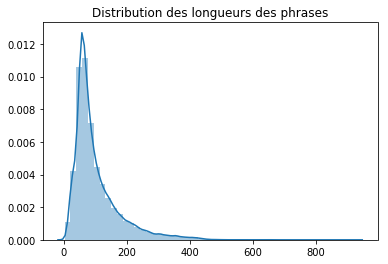

In [10]:
import seaborn as sns
sns.distplot([len(seq) for seq in encoded_X_train])
plt.title('Distribution des longueurs des phrases')
plt.show()

On doit d'abord définir la longueur des phrases que nous allons donner à notre réseau bi-LSTM.

In [11]:
seq_len = 250
v = int(np.sum(np.array([len(seq) for seq in encoded_X_train])<seq_len)/len(encoded_X_train)*100)
print('En choisissant seq_len=',seq_len,',', v,'% des phrases ne seront pas coupés.')

En choisissant seq_len= 250 , 94 % des phrases ne seront pas coupés.


In [25]:
from keras.preprocessing.sequence import pad_sequences

def preprocess(encoded_X, seq_len, top_unigrams):
    return to_categorical(pad_sequences(encoded_X,seq_len), num_classes = len(top_unigrams)+1)

preprocessed_X_train = preprocess(encoded_X_train, seq_len, top_unigrams)
preprocessed_X_test = preprocess(encoded_X_test, seq_len, top_unigrams)

In [26]:
from keras.layers import Dense, CuDNNLSTM, Dropout, Bidirectional, LSTM

In [33]:
hidden_size_lstm1 = 128
input_shape = (seq_len, len(top_unigrams)+1)
output_size = 1
use_dropout = True
lstm_dropout = 0.15
nb_epochs = 2
batch_size = 128

In [34]:
model = Sequential()
model.add(Bidirectional(LSTM(hidden_size_lstm1, return_sequences=True), input_shape = input_shape))
if use_dropout: model.add(Dropout(rate = lstm_dropout))
model.add(Bidirectional(LSTM(output_size), merge_mode='ave'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 250, 256)          5253120   
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 256)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1)                 2064      
Total params: 5,255,184
Trainable params: 5,255,184
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
model.fit(preprocessed_X_train, y_train, epochs=nb_epochs, batch_size=batch_size, validation_split = 0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/2
2700/2700 [==============================] - ETA: 21:20 - loss: 13.3978 - acc: 0.0000e+0 - ETA: 13:54 - loss: 7.9949 - acc: 0.0000e+0 - ETA: 10:47 - loss: 6.0068 - acc: 0.0000e+ - ETA: 9:10 - loss: 4.9421 - acc: 0.0000e+00 - ETA: 8:00 - loss: 4.2632 - acc: 0.0000e+0 - ETA: 7:13 - loss: 3.7880 - acc: 0.0000e+0 - ETA: 6:34 - loss: 3.4348 - acc: 0.0000e+0 - ETA: 6:01 - loss: 3.1599 - acc: 0.0000e+0 - ETA: 5:27 - loss: 2.9387 - acc: 0.0000e+0 - ETA: 4:55 - loss: 2.7545 - acc: 0.0000e+0 - ETA: 4:23 - loss: 2.5988 - acc: 0.0000e+0 - ETA: 3:53 - loss: 2.4642 - acc: 0.0000e+0 - ETA: 3:25 - loss: 2.3427 - acc: 0.0000e+0 - ETA: 2:57 - loss: 2.2317 - acc: 0.0000e+0 - ETA: 2:31 - loss: 2.1299 - acc: 0.0312    - ETA: 2:05 - loss: 2.0361 - acc: 0.086 - ETA: 1:40 - loss: 1.9481 - acc: 0.137 - ETA: 1:15 - loss: 1.8641 - acc: 0.185 - ETA: 50s - loss: 1.7842 - acc: 0.228 - ETA: 26s - loss: 1.7086 - acc: 0.26 - ETA: 2s - loss: 1.6376 - acc: 0.3021 

**c) Word Embeddings**

Pour améliorer le modèle précédent, on va utiliser des *word embeddings* (ou plongements vectoriels) pré-entraînés. 

On utilisera un modèle Skip-gram de dimension $d=300$ entraîné sur English Wikipedia, disponible à l'adresse [http://vectors.nlpl.eu/explore/embeddings/en/models/](http://vectors.nlpl.eu/explore/embeddings/en/models/). Dans cette archive, vous trouverez les embeddings dans un fichier `.txt` tel que 
- la première ligne du fichier indique le nombre de mots dans le vocabulaire et la dimension des embeddings
- chacune des lignes suivantes est composée d'un mot_étiquette grammaticale suivi des 300 coordonnées de son *embedding*, le tout séparé par des espaces. 

Ainsi, les premières lignes de ce fichier sont :
```
296630 300
also_ADV -0.010121 -0.045202 -0.065609 ... -0.065423
one_NUM -0.060427 0.005032 -0.076370 ... -0.107769
first_ADJ 0.005799 0.024848 0.018902 ...  -0.097193
...
```

Les étiquettes `_ADV`, `_NUM`, `_ADJ`, etc. indiquent l'étiquette grammaticale du mot et peuvent être supprimées pour ce TP.

*Note :* vous pouvez utiliser le snippet suivant pour télécharger et dézipper automatiquement les embeddings (pratique si vous utilisez une machine distante comme Google Colab) :
```python
import requests
import io
from zipfile import ZipFile

res = requests.get("http://link/to/archive.zip")
with ZipFile(io.BytesIO(res.content)) as z:
  z.extractall("extract/to/dir/")
```


Implémentez un modèle bi-LSTM qui utilisent ces *embeddings* pour représenter les mots d'une phrase. Vous pourrez utiliser le layer [Embedding](https://keras.io/layers/embeddings/) de Keras.

In [39]:
import requests
import io
from zipfile import ZipFile

res = requests.get("http://vectors.nlpl.eu/repository/11/3.zip")
with ZipFile(io.BytesIO(res.content)) as z:
    z.extractall("./")

# with ZipFile("/content/gdrive/My Drive/INF8460/db.zip", 'r') as z:
#     z.extractall("/content/gdrive/My Drive/INF8460/")

In [41]:
with open("./model.txt",'r', encoding = 'utf-8') as file:
    pretrained_word2vec = file.read()
    
pretrained_word2vec = pretrained_word2vec.split('\n')

also_ADV -0.010121 -0.045202 -0.065609 0.015132 0.067412 0.067457 0.005200 -0.153164 -0.050638 -0.081471 0.053971 0.074861 -0.062235 0.091584 -0.048601 -0.023214 0.052767 -0.076846 -0.033229 -0.007595 -0.054715 0.064596 -0.010630 -0.065153 -0.031456 0.052015 0.005636 -0.041579 0.043295 -0.044257 0.025818 0.005696 0.110534 0.013128 -0.002946 -0.004512 0.039517 0.069489 0.020679 -0.067730 -0.005763 -0.042992 -0.013484 -0.082801 -0.066724 0.127138 0.041764 -0.002434 0.006208 0.016155 -0.044741 -0.079362 -0.030341 -0.017210 0.012339 -0.101248 -0.094563 0.011798 -0.042924 -0.042762 -0.036247 0.077573 -0.066359 -0.011267 0.003298 0.062303 -0.091183 -0.079705 0.082605 0.002720 0.031884 0.126548 -0.046439 -0.030660 -0.006838 -0.037806 -0.011841 0.021648 0.016093 -0.045517 -0.010233 0.016172 -0.004578 -0.012521 0.063142 0.055941 0.008301 -0.034055 -0.015036 -0.075381 0.079510 0.015551 0.073754 -0.116458 0.081208 -0.067220 0.010879 0.052340 0.017293 0.049937 0.017848 -0.009775 0.027912 0.078304 

In [0]:
vocab_size = int(pretrained_word2vec[0].split()[0])
embedding_dim = int(pretrained_word2vec[0].split()[1])
seq_len = 100                                                   # A TROUVER       
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

296630

In [0]:
from keras.layers import Dense, CuDNNLSTM, Dropout, Bidirectional, LSTM, Embedding

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_len=seq_len, weights=[M], trainable=False))
model.add(Bidirectional(CuDNNLSTM(hidden_size_lstm1, return_sequences=True, input_shape = input_shape)))
if use_dropout: model.add(Dropout(rate = lstm_dropout))
model.add(Bidirectional(CuDNNLSTM(output_size), merge_mode='ave'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.build((None,input_shape[0],input_shape[1]))
print(model.summary())

### 5. Évaluation

**d)** Indiquez les performances de chacun de vos modèles. Comparez avec les modèles Naive Bayes et character-LM du TP précédent et commentez.

Quel est votre meilleur modèle ?